In [70]:
# Imports
import os
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score
from sklearn.model_selection._split import train_test_split
import sklearn
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn import preprocessing
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, MaxPooling1D, TimeDistributed, GRU
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf
from tqdm import tqdm
from matplotlib import pyplot as plt


In [2]:
def prepare_sequences(sampl, window_size=100, shift=1): #prepare windows with a given size
    data_set = np.array([])
    labels = np.array([])
    temp_labels = sampl[:, 0]
    sampl = sampl[:, 1:]
    print(sampl.shape)
    for row_index in tqdm(range(0, sampl.shape[0] - window_size, shift)):
        if(row_index == 0):
            data_set = np.array([sampl[row_index : window_size]])
            labels = np.append(labels, temp_labels[row_index])
        else:
            if(temp_labels[row_index] == temp_labels[row_index + window_size]):
                window = sampl[row_index : row_index + window_size]
                data_set = np.append(data_set, [window], axis = 0)
                labels = np.append(labels, temp_labels[row_index])
    return data_set, labels

def load_data(file, nrows = None):
    path = "{}/{}".format("new_data_different_texts", file)
    data = pd.read_csv(path, sep=",", header = None, nrows = nrows) 
    return pd.DataFrame(data)

In [3]:
files = os.listdir("{}".format("new_data_different_texts"))
frames = []
number_of_rows = 1500

for file in files: 
    print(file)
    data = load_data(file, number_of_rows)
    frames.append(data)
    
data = pd.concat(frames)
data = np.array(data)
data = data[:, :-1]

001001.txt
002001.txt
003001.txt
004001.txt
005001.txt
006001.txt
007001.txt
008001.txt
009001.txt
010001.txt
011001.txt
012001.txt
013001.txt
014001.txt
015001.txt
016001.txt
017001.txt
018001.txt
019001.txt
020001.txt


In [4]:
print(data)
keys = data[:, 1:3]
for row in range(keys.shape[0]):
    for column in range(keys.shape[1]):
        data[row, column + 1] = data[row, column + 1].lower().replace(" ", "")
        
print(data)

[[1 ' LMenu' ' Tab' ... 187 312 125]
 [1 ' Tab' ' LMenu' ... 172 1139 967]
 [1 ' LMenu' ' Tab' ... 124 218 94]
 ...
 [20 ' T' ' Space' ... 92 405 313]
 [20 ' Space' ' D1' ... 83 185 102]
 [20 ' D1' ' LControlKey' ... 975 10707 9732]]
[[1 'lmenu' 'tab' ... 187 312 125]
 [1 'tab' 'lmenu' ... 172 1139 967]
 [1 'lmenu' 'tab' ... 124 218 94]
 ...
 [20 't' 'space' ... 92 405 313]
 [20 'space' 'd1' ... 83 185 102]
 [20 'd1' 'lcontrolkey' ... 975 10707 9732]]


In [5]:
enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
enc.fit(np.concatenate((data[:,1], data[:,2]), axis=0).reshape(-1, 1))

first_column = enc.transform(data[:,1].reshape(-1, 1)).toarray()
second_column = enc.transform(data[:,2].reshape(-1, 1)).toarray()


In [6]:
# letters encoding - order: A1A2 B1B2 etc.
encoded_letters = [[]]

for i in range(0, first_column.shape[1]):
    if(i == 0):
      encoded_letters = np.column_stack((first_column[:, i], second_column[:, i]))
    else:
      encoded_letters = np.column_stack((encoded_letters, first_column[:, i], second_column[:, i]))


In [7]:
# normalization - z score
std_scaler = StandardScaler()
encoded_letters_scaled = std_scaler.fit_transform(encoded_letters) 
time_values_scaled = std_scaler.fit_transform(data[:, 3:])

In [8]:
prepared_data = np.column_stack((data[:, 0], encoded_letters_scaled, time_values_scaled))

In [9]:
def prepare_data(data, window_size, random_state = 1):
    data, labels = prepare_sequences(data, window_size = window_size, shift = int(window_size*0.4))
    samples = data
    samples = np.asarray(samples).astype('float32')
    labels = np.asarray(labels).astype('float32')
    (trainSamples, testSamples, trainLabels, testLabels) = sklearn.model_selection.train_test_split(samples, labels, test_size=0.25, random_state=random_state)

    #one hot encoding
    enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
    enc.fit(np.concatenate((trainLabels, testLabels), axis=0).reshape(-1, 1))
    print(trainLabels)
    trainLabels = enc.transform(trainLabels.reshape(-1, 1)).toarray()
    testLabels = enc.transform(testLabels.reshape(-1, 1)).toarray()
    print(trainLabels)
    
    return (trainSamples, testSamples, trainLabels, testLabels, samples, enc)

In [10]:
def print_history_params(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    plt.plot(epochs, acc, 'y', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [11]:
def build_model(conv_filters, kernel_size, gru_neurons, dropout):    
    n_classes = 20
    
    inputShape = (samples.shape[1],samples.shape[2])
    print('inputShape:',inputShape)
    model = Sequential()
    
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu', input_shape=inputShape))
    model.add(Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu'))    
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout))
    
    model.add(GRU(gru_neurons, return_sequences=True))
    model.add(GRU(gru_neurons))
    model.add(Dropout(dropout))
    model.add(Dense(gru_neurons, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    return model

In [68]:
def train_model(model, optimizer):
    model.compile(loss='categorical_crossentropy', 
                  optimizer= optimizer,
                  metrics=['accuracy'])
    
    EPOCHS=100
    BATCH=64
    
    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
    ]
    
    history = model.fit(trainSamples, trainLabels, batch_size=BATCH, epochs=EPOCHS
            ,validation_data=(testSamples,testLabels)
            ,callbacks=my_callbacks)
    print_history_params(history);

In [13]:
def get_metrics(model):
    testResults = model.predict(testSamples)
    
    matrix = confusion_matrix(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    report = classification_report(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    accuracy = accuracy_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    cohen_kappa = cohen_kappa_score(testLabels.argmax(axis=1), testResults.argmax(axis=1))
    return (matrix, report, accuracy, cohen_kappa)

def print_metrics(matrix, report, accuracy, cohen_kappa):
    print(matrix)
    print(report)
    print("Accuracy: {:.2f}".format(accuracy))
    print("Cohen's Kappa: {:.2f}".format(cohen_kappa))

In [14]:
from contextlib import redirect_stdout

def save_model(model, test):          
    directory = "{}/{}".format("results", f"free_input_{test}")
    if not os.path.exists(directory):
        os.makedirs(directory)
    os.chdir(directory)
    
    with open(f"{test}",'a') as f:
        with redirect_stdout(f):
            model.summary()
        
    os.chdir("../..")

In [15]:
def save_results(test, parameters, matrix, report, accuracy, cohen_kappa):
    confusion_matrix = np.array2string(matrix)
        
    directory = "{}/{}".format("results", f"free_input_{test}")
    if not os.path.exists(directory):
        os.makedirs(directory)
    os.chdir(directory)
    f=open(f"{test}",'a')
    f.write('\nParameters\n\n{}\n\nConfusion Matrix\n\n{}\n\nClassification Report\n\n{}\n\nAccuracy: {}\nCohen Kappa: {}\n'
            .format(parameters, confusion_matrix, report, accuracy, cohen_kappa ))
    f.close()
    os.chdir("../..")


In [16]:
def prepare_parameters_to_save(window_size, cnn_filters, rnn_neurons, kernel, dropout):
    return 'Window size: {}\nCnn filters: {}\nRnn neurons: {}\nKernel size: {}\nDropout: {}\n'.format(window_size,cnn_filters, rnn_neurons, kernel, dropout)

In [66]:
def manage_results(model, cnn_filters, rnn_neurons):
    (matrix, report, accuracy, cohen_kappa) = get_metrics(model)
    print_metrics(matrix, report, accuracy, cohen_kappa)
    save_model(model, test)
    parameters = prepare_parameters_to_save(window_size, cnn_filters, rnn_neurons, kernel, dropout)
    save_results(test, parameters, matrix, report, accuracy, cohen_kappa)
    return matrix, accuracy

  3%|██▍                                                                            | 57/1872 [00:00<00:03, 545.28it/s]

(29985, 130)


100%|██████████████████████████████████████████████████████████████████████████████| 1872/1872 [01:42<00:00, 18.24it/s]


[13.  9.  3. ... 13.  3. 12.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
inputShape: (40, 130)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 39, 128)           33408     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 38, 128)           32896     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 128)           0         
_________________________________________________________________
gru (GRU)                    (None, 19, 128)           99072     
______________________________________________

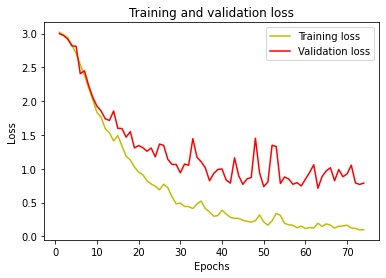

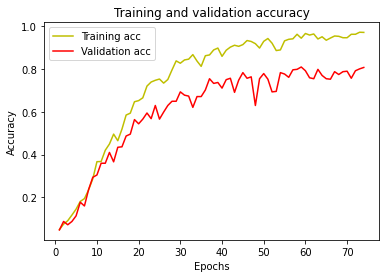

[[19  2  0  1  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0 18  0  0  0  0  1  0  0  2  0  0  0  0  0  0  1  0  0  0]
 [ 0  0 12  0  0  1  0  0  0  0  2  1  2  0  0  0  0  0  2  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 24  0  0  1  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 25  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0 16  2  0  0  0  0  0  0  0  1  0  1]
 [ 0  1  0  0  0  0  0  0  1 16  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  3 10  2  2  0  0  0  3  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0  3  0 18  0  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  1  0  0  1  0  0  0  0  0  0  0  0 18  0  0  0  0  0]
 [ 0  1  0  0  2  2  0  0  0  3  2  4  0  0  0 13  0  0

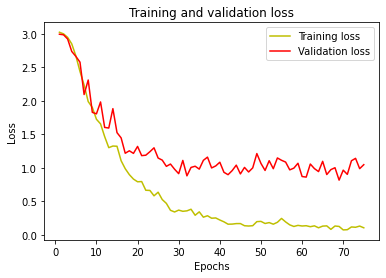

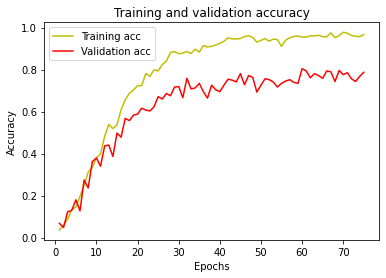

[[12  0  0  1  0  0  0  0  0  0  0  0  0  6  0  0  4  1  0  0]
 [ 2 17  0  0  0  0  0  0  0  1  0  0  0  0  0  0  2  0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0]
 [ 0  0  0 24  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  2  0  0  1  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 12  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 22  0  0  0  2  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  2  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  6 16  0  0  0  0  0  0  0  1]
 [ 0  0  2  0  0  0  0  0  0  0  1  0 18  0  0  0  2  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0  0  0  0 19  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0]
 [ 0  1  0  0  1  0  0  0  3  2  1  1  2  0  0 15  1  0

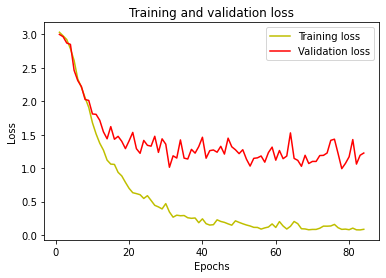

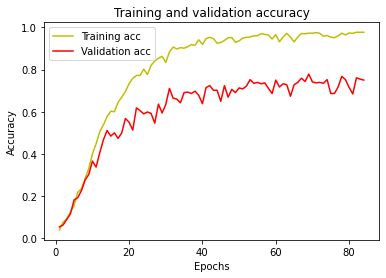

[[18  3  0  1  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0 20  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 15  0  0  0  0  0  0  0  1  1  2  0  1  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0 16  0  4  0  0  0  1  0  3  0  0  0  0  0  0  0]
 [ 0  0  1  0  0 10  0  0  0  0  1  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  1  0 16  0  0  2  4  2  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  1  1  0  1  0 11  0  0  0  0  1  0  2  2  0  0  1]
 [ 0  1  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  1  0  0  2 16  0  0  0  0  0  1  0  0  0]
 [ 0  0  1  0  0  0  4  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  0  1  0  0  0  0  0 17  0  0  0  1  0  0  0]
 [ 0  0  0  2  0  0  0  1  0  0  0  0  0 18  0  0  0  0  0  0]
 [ 0  0  1  0  0  3  0  0  0  0  0  0  0  0 16  0  0  0  0  0]
 [ 0  0  2  0  0  0  1  1  0  2  1  0  0  0  0 20  0  0

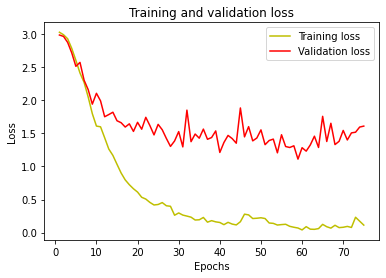

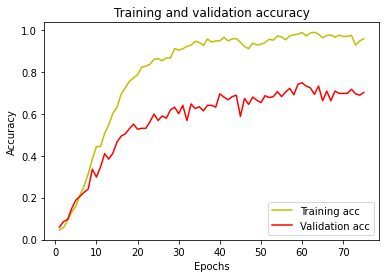

[[18  0  0  1  0  0  0  1  2  0  0  0  0  0  0  0  1  1  0  0]
 [ 0 19  0  0  0  0  0  0  1  1  0  0  0  0  0  0  1  0  0  0]
 [ 0  0 14  0  3  1  0  0  0  0  0  0  1  0  0  0  0  0  1  0]
 [ 0  0  0 22  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0 13  1  3  0  0  1  0  1  2  0  1  0  1  0  1  0]
 [ 0  0  0  0  0 12  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  3 13  0  0  3  2  2  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 22  1  1  0  0  0  0  0  0  0  0  1  0]
 [ 0  1  0  0  0  0  0  0 15  4  0  0  1  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0 17  1  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  2  1  0  0  4  8  2  1  0  0  1  0  0  2  0]
 [ 0  0  0  0  0  2  2  0  0  0  0 16  0  0  2  0  0  0  1  1]
 [ 0  1  1  0  0  3  1  0  0  1  0  0 15  0  0  0  0  0  1  0]
 [ 1  0  0  2  0  0  0  1  0  0  0  0  0 17  0  0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
 [ 0  4  0  0  1  0  1  0  0  3  3  0  3  0  0 11  0  0

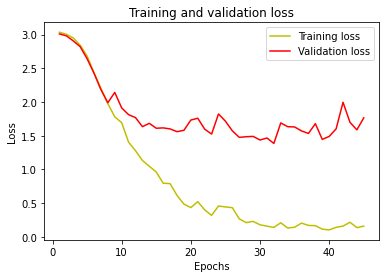

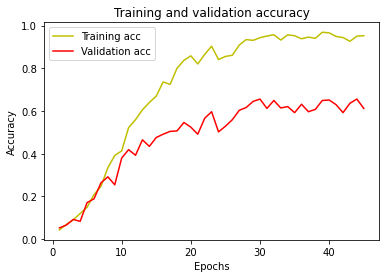

[[19  2  0  0  0  0  0  0  0  1  0  0  0  2  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  1  1  0  0  0  0  0  1  0  0  0]
 [ 0  0 18  0  0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0]
 [ 0  0  0 12  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  2  0 14  1  0  0  0  0  1  0  2  0  1  0  2  0  1  0]
 [ 0  0  1  0  0 11  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  4  0  0  3  0 12  0  0  0  2  2  2  0  0  1  0  0  0  0]
 [ 0  7  0  1  0  0  0 11  0  3  0  0  0  2  0  0  0  0  1  0]
 [ 2  4  1  0  0  0  0  0 10  0  0  0  0  0  0  0  2  3  0  0]
 [ 0  3  0  0  2  0  1  0  0 12  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  1  1 15  0  1  0  0  0  0  0  2  0]
 [ 0  0  2  0  2  1  1  0  0  0  0 14  1  0  0  0  0  0  3  0]
 [ 0  1  3  0  4  0  0  0  0  0  1  1 12  0  0  0  0  0  1  0]
 [ 4  0  0  0  0  0  0  2  0  0  0  0  0 15  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 17  0  0  0  2  0]
 [ 0  3  4  0  1  1  1  1  0  3  4  1  0  0  0  7  0  1

In [19]:
window_size = 40
filters = 128
neurons = 128
kernels = [2,3,4,5,6]
dropout = 0.5
accuracy = 0
best_kernel = kernels[0]

test = f"test4a_{window_size}"
(trainSamples, testSamples, trainLabels, testLabels, samples, enc) = prepare_data(prepared_data, window_size)
for kernel in kernels:
    model = build_model(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    new_accuracy = manage_results(model, filters, neurons)
    if(new_accuracy > accuracy):
        accuracy = new_accuracy
        best_kernel = kernel

inputShape: (40, 130)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 39, 128)           33408     
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 38, 128)           32896     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 19, 128)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 19, 128)           0         
_________________________________________________________________
gru_10 (GRU)                 (None, 19, 128)           99072     
_________________________________________________________________
gru_11 (GRU)                 (None, 128)               99072     
_________________________________________________________________
dropout_11 (Dropout)         (No

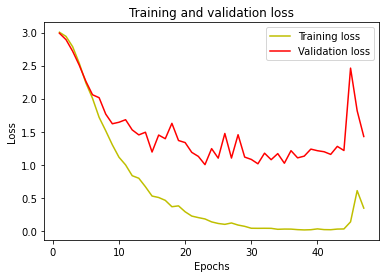

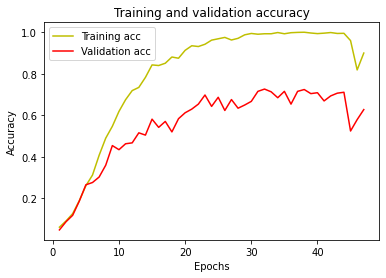

[[13  1  0  1  0  0  0  1  1  0  0  0  0  4  0  0  3  0  0  0]
 [ 3  6  0  0  0  0  1  5  3  0  0  0  0  1  0  1  2  0  0  0]
 [ 0  0 12  0  1  0  0  0  0  0  0  0  5  0  0  0  0  0  2  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  1  0  0  0  0  1  3  0  0  0  0  0  0  2]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  5  0 11  0  0  1  2  3  1  0  0  0  0  0  0  3]
 [ 0  0  0  0  0  0  0 24  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  1  0  1  0 16  0  0  0  0  0  0  0  0  2  0  1]
 [ 0  1  0  0  0  0  0  0  1 13  0  0  0  0  0  1  2  0  0  0]
 [ 0  0  4  0  1  1  1  0  1  3  4  1  3  0  0  1  1  0  0  1]
 [ 0  0  4  0  2  3  4  0  0  0  0  3  1  0  0  0  0  0  5  2]
 [ 0  0  4  0  2  0  0  0  0  0  0  0 15  0  0  0  0  0  2  0]
 [ 0  0  0  4  0  0  0  0  0  0  0  0  0 17  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0 18  0  0  0  1  0]
 [ 4  0  1  0  2  2  1  0  2  1  0  0  2  0  0 11  0  1

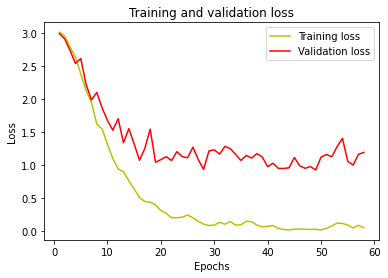

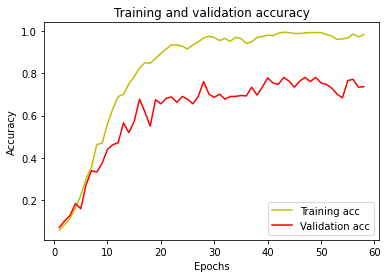

[[18  2  0  1  0  0  0  0  0  0  0  0  0  2  0  0  0  1  0  0]
 [ 2 19  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0 17  0  0  2  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  4  0 11  0  0  0  0  0  3  0  2  0  0  1  0  1  1  1]
 [ 0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  1 23  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  1  0  0  0  0 15  2  0  0  0  0  0  0  0  2  0  0]
 [ 0  2  0  0  0  0  0  0  0 13  2  0  0  0  0  1  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  1 14  1  2  0  0  2  1  0  0  0]
 [ 0  0  3  0  0  4  1  0  0  0  3 10  0  0  0  0  0  0  3  0]
 [ 0  0  7  0  0  2  0  0  0  0  1  0 13  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  1  0  0  0  0  0 19  0  0  0  0  0  0]
 [ 0  0  3  0  0  2  0  0  0  0  0  0  0  0 15  0  0  0  0  0]
 [ 1  1  0  0  1  3  0  0  1  0  1  1  0  0  0 17  0  1

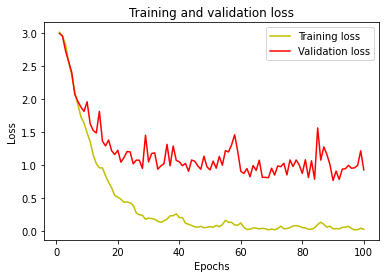

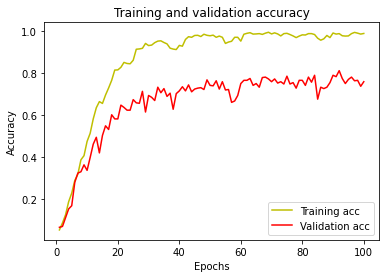

[[23  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3 18  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  1  0  0  0  0  1  0  1  0  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 17  0  0  0  3  0  0  1  0  0  0  0  0  1  0  1]
 [ 0  0  0  0  0 12  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1 22  0  0  0  2  1  0  0  0  0  0  0  0  0]
 [ 1  0  0  1  0  0  0 22  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  1  0  0  0 18  0  0  0  0  0  0  0  0  1  0  0]
 [ 3  2  0  0  0  0  0  0  0 11  2  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  1  0  0  3 14  0  0  0  0  0  1  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  5 13  0  0  0  4  0  0  2  0]
 [ 0  0  3  0  1  0  0  0  0  0  5  0 13  0  0  0  1  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  1  0  0  1  0  0  0  0  0  0  0  0 16  0  0  0  2  0]
 [ 1  1  0  0  0  0  0  1  1  2  2  0  0  0  0 19  0  0

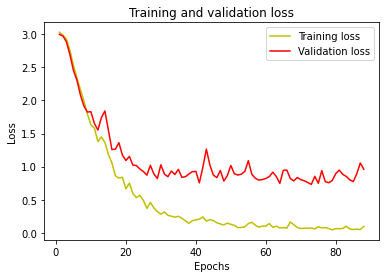

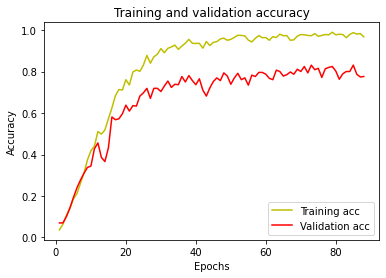

[[14  3  0  0  0  0  0  0  0  0  0  0  0  1  0  0  6  0  0  0]
 [ 0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 11  0  0  3  0  0  0  0  2  0  2  0  2  0  0  0  0  0]
 [ 1  0  0 21  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0 21  0  0  0  0  0  0  2  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0 24  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0  0 16  0  0  0  0  1  0  0  2  0  0  1]
 [ 0  0  0  0  0  0  1  0  0 14  1  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  1  0  5  0  0  0 10  1  1  0  0  0  4  0  0  0]
 [ 0  0  1  0  0  0  3  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  1  1  0  0  0  0  0 19  0  0  0  0  0  0  1]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  2  0  0  1  0  0  0  0  0  0  0  0 17  0  0  0  0  0]
 [ 0  0  0  0  2  1  1  0  0  3  1  1  3  0  0 13  2  0

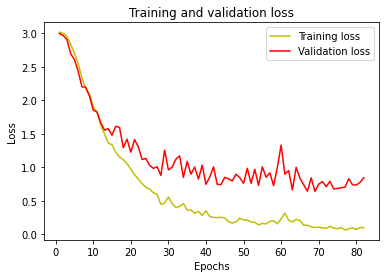

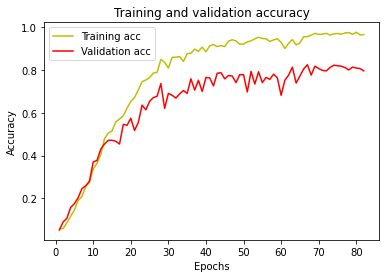

[[20  0  0  3  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 2 16  0  0  0  0  0  0  0  2  0  0  0  0  0  0  2  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 26  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 19  0  0  0  0  0  0  0  1  0  0  0  2  0  0  1]
 [ 0  0  0  0  0 12  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 24  0  0  0  1  1  0  0  0  0  0  0  0  0]
 [ 0  1  0  2  0  0  0 22  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 17  0  0  0  0  0  0  1  0  2  0  1]
 [ 1  0  0  0  0  0  0  0  0 14  1  0  0  0  0  0  2  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  1 16  0  0  0  0  0  4  0  0  0]
 [ 0  0  0  0  0  0  3  0  0  0  3 18  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  1  0  0  0  0  3  1 14  0  0  0  1  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  2  0  0  2  0  0  0  0  0  0  0  0 16  0  0  0  0  0]
 [ 1  0  0  0  1  1  0  0  1  0  1  0  1  0  0 20  1  0

In [20]:
window_size = 40
filters = 128
neurons = 128
kernel = best_kernel
dropouts = [0.1, 0.2, 0.3, 0.4, 0.5]


test = f"test4b_{window_size}"
# (trainSamples, testSamples, trainLabels, testLabels, samples, enc) = prepare_data(prepared_data, window_size)
for dropout in dropouts:
    model = build_model(filters, kernel, neurons, dropout) 
    train_model(model, 'Adam')
    manage_results(model, filters, neurons)

In [21]:
best_kernel

2

In [22]:
accuracy

0.8070175438596491

inputShape: (40, 130)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 39, 128)           33408     
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 38, 128)           32896     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 19, 128)           0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 19, 128)           0         
_________________________________________________________________
gru_30 (GRU)                 (None, 19, 128)           99072     
_________________________________________________________________
gru_31 (GRU)                 (None, 128)               99072     
_________________________________________________________________
dropout_30 (Dropout)         (N

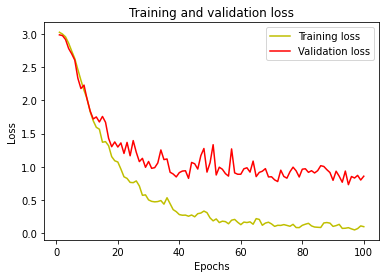

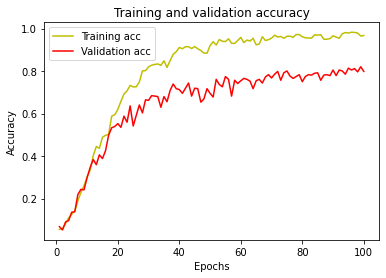

[[20  3  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 13  0  2  1  0  0  0  0  0  1  2  0  1  0  0  0  0  0]
 [ 0  0  0 22  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0 18  0  0  0  1  0  0  1  1  0  0  0  1  1  0  1]
 [ 0  0  1  0  0 11  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0 23  0  0  0  1  0  0  0  0  1  0  0  0  0]
 [ 0  2  0  0  0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  2  0  0]
 [ 1  1  0  0  0  0  0  0  0 14  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  1  0  2  0  0  0  8  1  2  0  0  0  8  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  2 20  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  2  0  0  0  1  0  0  0 19  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 19  0  0  0  1  0]
 [ 2  0  0  0  1  0  0  0  1  2  1  1  2  0  0 17  0  0

In [71]:
model = build_model(filters, kernel, neurons, dropout) 
train_model(model, 'Adam')
matrix, accuracy = manage_results(model, filters, neurons)


In [72]:
accuracy

0.7982456140350878

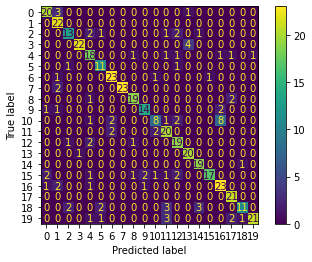

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=matrix) 
disp.plot()

In [74]:
cnf_matrix = matrix
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix) 
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)
FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Overall accuracy for each class
ACC = (TP+TN)/(TP+FP+FN+TN)


In [75]:
sumFPR = sum(FPR)/20

In [79]:
sumFPR

0.010619905310886097

In [76]:
sumFNR = sum(FNR)/20

In [80]:
sumFNR

0.20019430932774257

In [77]:
sum(ACC)/20

0.9798245614035086

In [78]:
EER = (sumFPR + sumFNR)/2

In [81]:
EER

0.10540710731931434

In [82]:
FNR

array([0.16666667, 0.        , 0.35      , 0.15384615, 0.25      ,
       0.15384615, 0.11538462, 0.08      , 0.13636364, 0.22222222,
       0.63636364, 0.16666667, 0.17391304, 0.04761905, 0.05      ,
       0.37037037, 0.17857143, 0.        , 0.47619048, 0.27586207])